In [197]:
library(dummies)
library(data.table)
library(randomForest)
library(cluster)
# library(fpc)
library(dbscan)

In [198]:
data <- read.csv(file='haberman.data',header=TRUE)
colnames(data) <- c('Age','year','AxillaryNodes','SurvivalStatus')
data <- na.omit(data)

In [199]:
data$SurvivalStatus[data$SurvivalStatus == 1] <- 0
data$SurvivalStatus[data$SurvivalStatus == 2] <- 1
class0 <- data[which(data$SurvivalStatus == 0),]
class1 <- data[which(data$SurvivalStatus == 1),]

In [200]:
noise <- function(class){
    sample_rows = sample(1:nrow(class), 0.2*nrow(class), replace=FALSE, prob=NULL)
    temp_data <- class[sample_rows,] 
    return(as.numeric(rownames(temp_data)))
}

In [201]:
noise0 <- noise(class0)
for(i in noise0){
    class0[toString(i),]$SurvivalStatus = !class0[toString(i),]$SurvivalStatus
}
noise1 <- noise(class1)
for(i in noise1){
    class1[toString(i),]$SurvivalStatus = !class1[toString(i),]$SurvivalStatus
}
nrow(class0)
nrow(class1)
noise_indices <- c(noise0, noise1)
print(length(noise_indices))
mislabeled_data <- rbind(class0,class1)
indices <- as.numeric(rownames(mislabeled_data))
str(mislabeled_data)

[1] 224

[1] 81

[1] 60
'data.frame':	305 obs. of  4 variables:
 $ Age           : int  30 30 31 31 33 33 34 34 34 34 ...
 $ year          : int  62 65 59 65 58 60 58 60 61 67 ...
 $ AxillaryNodes : int  3 0 2 4 10 0 30 1 10 7 ...
 $ SurvivalStatus: num  0 0 1 0 0 1 0 0 0 0 ...


 [1] 54137.666 30362.301 21023.153 15333.046 13457.695 11664.565  9978.882
 [8]  8981.156  8118.453  7470.661  7035.831  6564.325  6077.843  5668.368
[15]  5228.595  4988.488  4733.759  4484.549  4251.921  4128.759  3908.101
[22]  3852.189  3663.354  3522.555  3373.207


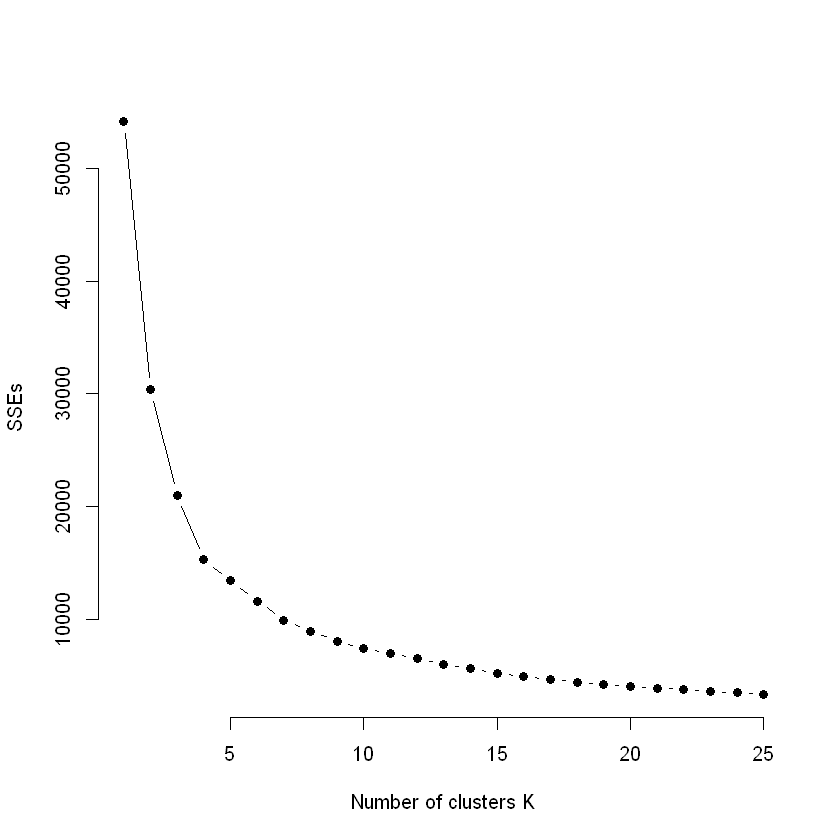

In [202]:
#Elbow_plot
k <- c(1:25)
SSE <- c()
for(i in k){
    clusters <- kmeans(mislabeled_data, i, nstart = 25)
    SSE <- c(SSE, clusters$tot.withinss)
}
print(SSE)
plot(k,SSE,type = "b", pch = 19, frame = FALSE, 
       xlab = "Number of clusters K",
       ylab = "SSEs")

In [203]:
# From above cluster analysis (Elbow Plot) we can conclude optimal number of clusters to be 4
temp <- mislabeled_data
temp$SurvivalStatus <- NULL
# summary(temp)
km <- kmeans(temp, 3,nstart=10)
# summary(km)
# print(km$cluster)
mislabeled_data$clusters=km$cluster 

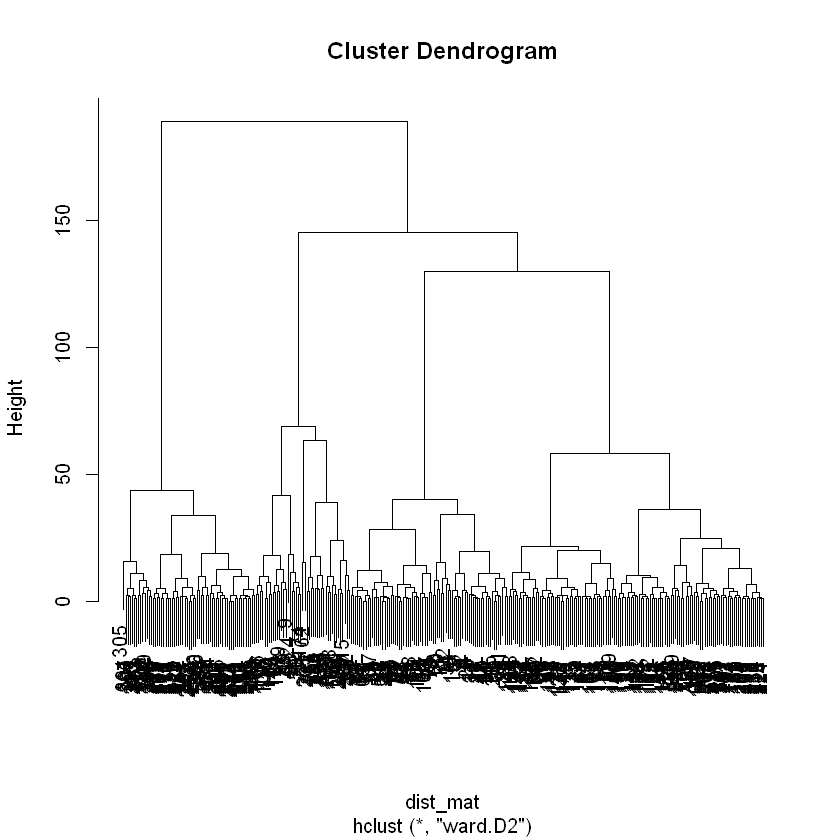

In [204]:
dist_mat <- dist(mislabeled_data, method='euclidean')
cluster <- hclust(dist_mat, method = 'ward.D2')
plot(cluster)

In [261]:
clusterC_vector <- cutree(cluster, k = 2)
ss <- silhouette(clusterC_vector, dist(mislabeled_data))
mean(ss[,3])
clusterC_vector <- cutree(cluster, k = 3)
ss <- silhouette(clusterC_vector, dist(mislabeled_data))
mean(ss[,3])
clusterC_vector <- cutree(cluster, k = 4)
ss <- silhouette(clusterC_vector, dist(mislabeled_data))
mean(ss[,3])

[1] 0.3373233

[1] 0.3595671

[1] 0.3365259

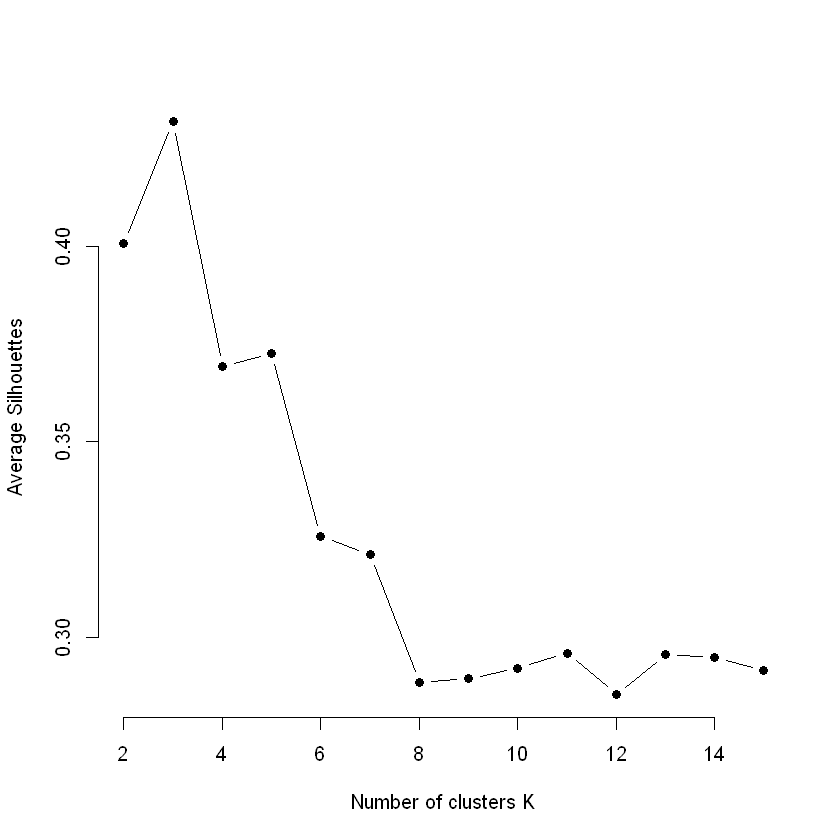

In [205]:
avg_sil <- function(k) {
  km.res <- kmeans(mislabeled_data, k, nstart = 25)
  ss <- silhouette(km.res$cluster, dist(mislabeled_data))
  mean(ss[, 3])
}

# Compute and plot wss for k = 2 to k = 15
k.values <- 2:15
avg_sil_values <- c()
# extract avg silhouette for 2-15 clusters
for(i in k.values){
    avg_sil_values <- c(avg_sil_values,avg_sil(i))
}


plot(k.values, avg_sil_values,
       type = "b", pch = 19, frame = FALSE, 
       xlab = "Number of clusters K",
       ylab = "Average Silhouettes")

In [206]:
mislabeled_data <- dummy.data.frame(mislabeled_data, names=c('clusters'), sep='_')
str(mislabeled_data)
head(mislabeled_data,3)

'data.frame':	305 obs. of  7 variables:
 $ Age           : int  30 30 31 31 33 33 34 34 34 34 ...
 $ year          : int  62 65 59 65 58 60 58 60 61 67 ...
 $ AxillaryNodes : int  3 0 2 4 10 0 30 1 10 7 ...
 $ SurvivalStatus: num  0 0 1 0 0 1 0 0 0 0 ...
 $ clusters_1    : int  0 0 0 0 0 0 1 0 0 0 ...
 $ clusters_2    : int  0 0 0 0 0 0 0 0 0 0 ...
 $ clusters_3    : int  1 1 1 1 1 1 0 1 1 1 ...
 - attr(*, "dummies")=List of 1
  ..$ clusters: int  5 6 7


Age,year,AxillaryNodes,SurvivalStatus,clusters_1,clusters_2,clusters_3
30,62,3,0,0,0,1
30,65,0,0,0,0,1
31,59,2,1,0,0,1


In [207]:
# RandomForestClassifier
set.seed(100)  # setting seed to reproduce results of random sampling
trainingRowIndex <- sample(1:nrow(data), 0.67*nrow(data))  # row indices for training data
trainingData <- mislabeled_data[trainingRowIndex, ]  # model training data
xtest <- mislabeled_data
testData  <- mislabeled_data[-trainingRowIndex, ]   # test data
trainingData$SurvivalStatus <- as.logical(trainingData$SurvivalStatus)
rf <- randomForest(as.factor(SurvivalStatus) ~ ., data=trainingData)
predicted = predict(rf,xtest) 
summary(predicted)
str(predicted)


FALSE  TRUE 
  260    45

 Factor w/ 2 levels "FALSE","TRUE": 1 1 2 1 1 2 1 1 1 1 ...
 - attr(*, "names")= chr [1:305] "1" "2" "3" "4" ...


In [208]:
mislabeled_data$predicted = predicted
# str(mislabeled_data)
# mislabeled_data$predicted<-as.numeric(mislabeled_data$predicted)
a<-mislabeled_data$predicted
b<-as.logical(mislabeled_data$SurvivalStatus)
# print(a)
# print(b)
a <- na.omit(a)
b <- na.omit(b)

detected <- c()
count <- 0
for(i in indices){
    if (a[i] != b[i]){
        detected <- c(detected,i)
        }
}
# print(a!=b)
for(i in detected){
    if (i %in% noise_indices){
        count=count+1
    }
}
print(count)
print(length(noise_indices))

[1] 18
[1] 60


In [251]:
mislabeled_data$predicted <- as.numeric(mislabeled_data$predicted)
db <- dbscan(as.matrix(data), eps=6, minPts=7)

In [252]:
print(db)

DBSCAN clustering for 305 objects.
Parameters: eps = 6, minPts = 7
The clustering contains 2 cluster(s) and 18 noise points.

  0   1   2 
 18 280   7 

Available fields: cluster, eps, minPts


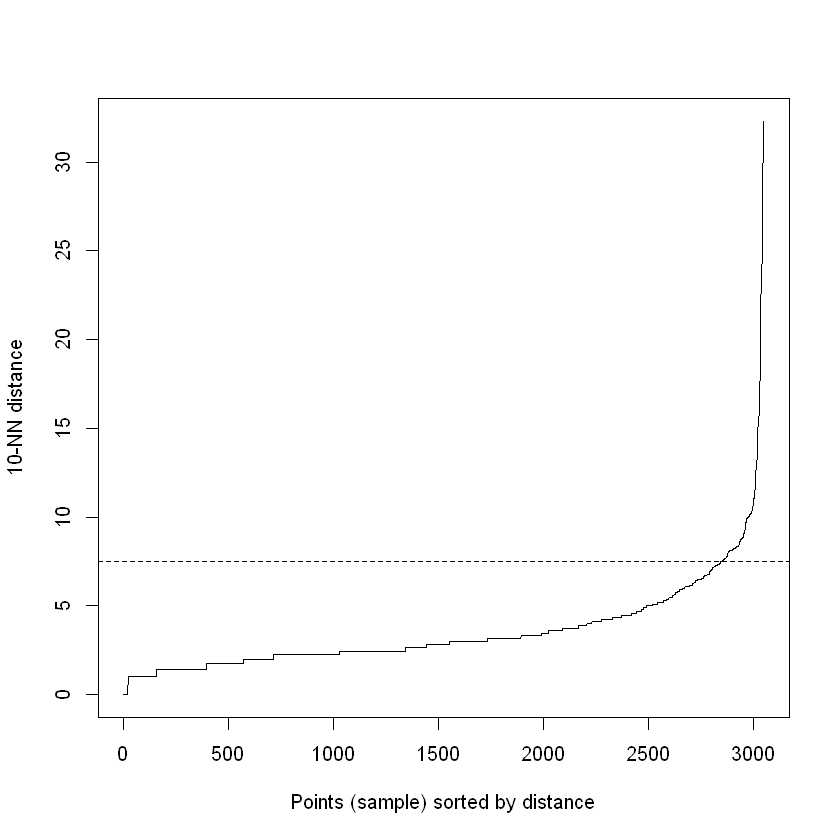

In [249]:
dbscan::kNNdistplot(mislabeled_data, k =  10)
abline(h = 7.5, lty = 2)

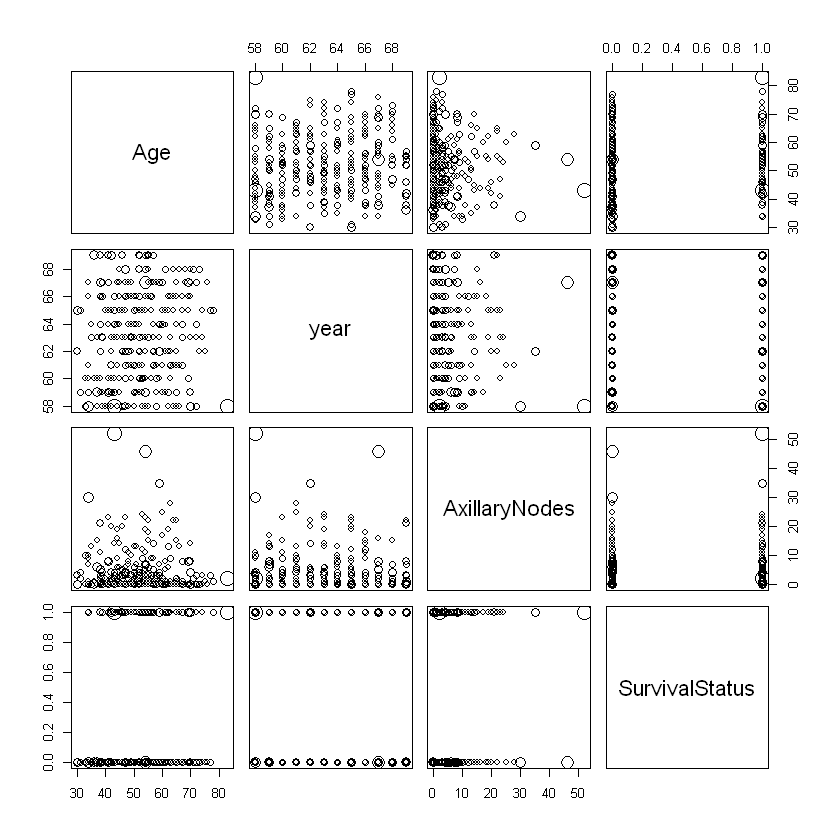

In [245]:
lof <- lof(as.matrix(data),k=5)
pairs(as.matrix(data), cex=lof)

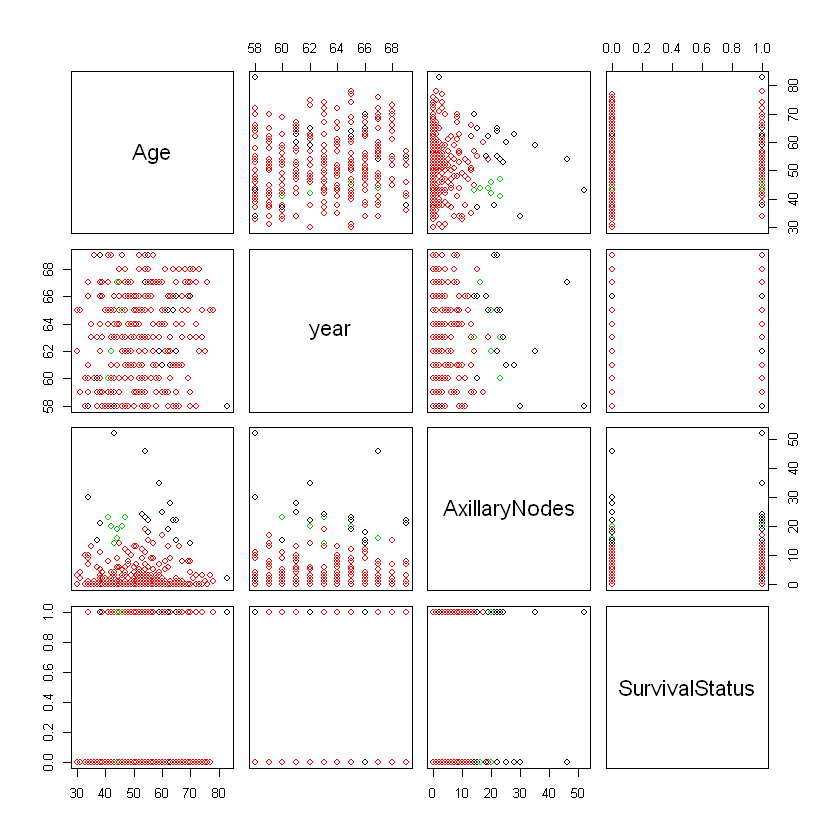

In [253]:
pairs(as.matrix(data), col = db$cluster + 1L)